In [1]:
import holidays
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings('ignore')

### Data preparation

In [2]:
df = pd.read_csv('data/covid19-clean.csv')
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, "%d %B %Y "))

In [3]:
data = df[['Date', 'Recovered']]
data.columns = ['ds', 'y']

In [4]:
holidays_pl = pd.DataFrame(holidays.PL(years = 2020), index = [0]).T.reset_index()
holidays_pl.columns = ['ds', 'holiday']
holidays_pl['lower_window'] = -1
holidays_pl['upper_window'] = 3

# Modeling

### Model creation

In [5]:
model_args = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 0.05,
    'holidays_prior_scale': 0.01,
    'weekly_seasonality': 8,
    'yearly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_range': 0.8,
    'holidays': holidays_pl,
    'mcmc_samples': 1000
}

In [6]:
model = Prophet(**model_args)
model.add_seasonality(name = '2-weekly', period = 14, fourier_order = 8, prior_scale = 0.05)
model.fit(data[40:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)

In [8]:
forecast = pd.merge(forecast, model.history[['ds', 'y']], on='ds')
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper
62,2020-06-08,143.0,156.726962,82.167932,229.083813
63,2020-06-09,198.0,247.130298,169.701840,321.824921
64,2020-06-10,215.0,268.779423,192.854779,337.909551
65,2020-06-11,285.0,246.727284,169.708374,319.425436
66,2020-06-12,109.0,188.702350,116.544640,265.247209
67,2020-06-13,299.0,267.227750,192.689968,342.825587
68,2020-06-14,122.0,196.305368,122.133132,274.274089
69,2020-06-15,157.0,172.885835,100.458338,248.217946
70,2020-06-16,271.0,234.652939,160.562682,307.695072
71,2020-06-17,267.0,273.195535,198.516094,348.934694


### Model explanation

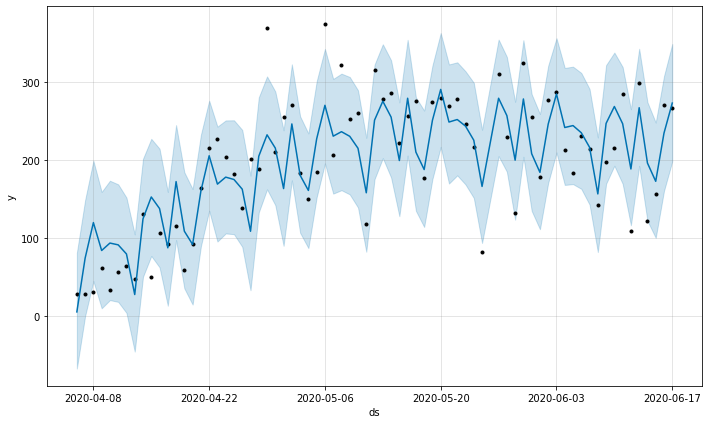

In [9]:
fig = model.plot(forecast)

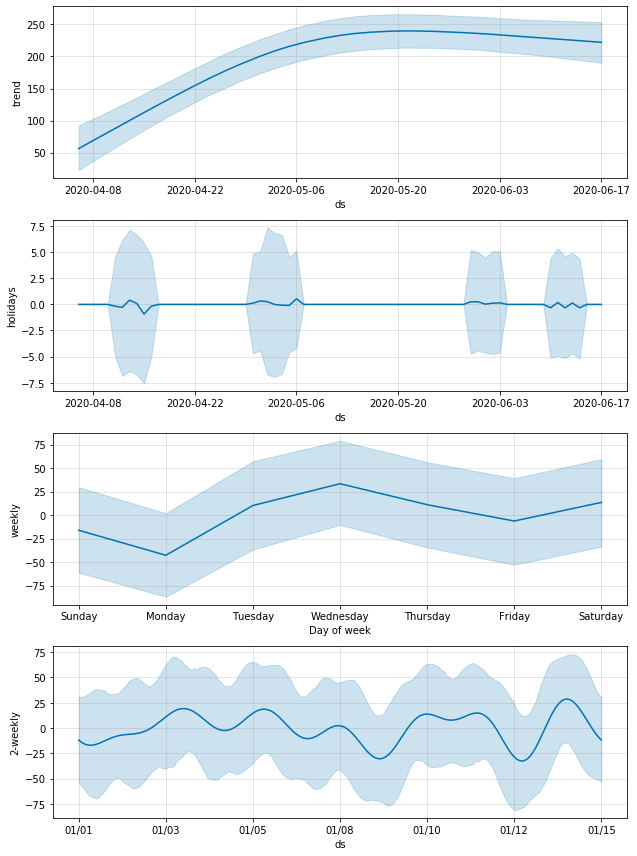

In [10]:
fig = model.plot_components(forecast, uncertainty=True)

### Model performance

In [11]:
results = cross_validation(model, initial = '65 days', horizon = '1 day', period = '1 day')
metrics = performance_metrics(results)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-06-10 00:00:00 and 2020-06-16 00:00:00


In [12]:
results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-11,241.403945,167.560926,323.010055,285.0,2020-06-10
1,2020-06-12,212.013309,131.505940,292.940810,109.0,2020-06-11
2,2020-06-13,258.996119,179.393342,341.838104,299.0,2020-06-12
3,2020-06-14,214.693344,140.272749,293.322349,122.0,2020-06-13
4,2020-06-15,172.361128,97.681158,247.250359,157.0,2020-06-14
5,2020-06-16,225.166331,145.055169,301.515986,271.0,2020-06-15
6,2020-06-17,275.102742,198.866618,352.558180,267.0,2020-06-16


In [13]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3586.724019,59.889265,49.80059,0.326991,0.152969,0.714286


### Tomorrow prediction

In [14]:
np.round(forecast.iloc[-1]['yhat']).astype(int)

273